In [1]:
import pandas as pd
import numpy as np

dridex = pd.read_csv("../Datasets/MalDIST/Dataset1/Dridex.csv", sep=",")
benign = pd.read_csv("../Datasets//MalDIST/Dataset1/Benign.csv", sep=",")
desktop_malware = pd.read_csv("../Datasets/MalDIST/Dataset2/desktop-malware.csv", sep=',')
desktop_apps = pd.read_csv("../Datasets/MalDIST/Dataset2/desktop-apps.csv", sep=',')
mydesktop_apps = pd.read_csv("../Datasets/MalDIST/Dataset2/mydesktop-apps.csv", sep=',')

print(f"The shape of the dridex dataset is {dridex.shape[0]} samples, {dridex.shape[1]} features")
print(f"The shape of the desktop malware dataset is {desktop_malware.shape[0]} samples, {desktop_malware.shape[1]} features")
print(f"The shape of the desktop apps dataset is {desktop_apps.shape[0]} samples, {desktop_apps.shape[1]} features")
print(f"The shape of the my desktop apps dataset is {mydesktop_apps.shape[0]} samples, {mydesktop_apps.shape[1]} features")
print(f"The shape of the benign dataset is {benign.shape[0]} samples, {benign.shape[1]} features")

The shape of the dridex dataset is 3138 samples, 201 features
The shape of the desktop malware dataset is 25174 samples, 201 features
The shape of the desktop apps dataset is 521 samples, 201 features
The shape of the my desktop apps dataset is 2651 samples, 201 features
The shape of the benign dataset is 2473 samples, 201 features


In [2]:
data = pd.read_csv("../Datasets/MalDIST/combined/MalDIST_Dataset.csv", sep=",")

mal = data[data['label'] == 1].drop(columns=['label'])
legit = data[data['label'] == 0].drop(columns=['label'])

print(f"The shape of the legit dataset is {legit.shape[0]} samples, {legit.shape[1]} features")
print(f"The shape of the mal dataset is {mal.shape[0]} samples, {mal.shape[1]} features")

The shape of the legit dataset is 5645 samples, 200 features
The shape of the mal dataset is 28312 samples, 200 features


In [3]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separar características y etiquetas
X = data.drop(columns=['label', 'family', 'file_name'])
y = data['label']

# Tamaño objetivo de las clases balanceadas
target_class_size = 10000  


subsampled_dfs = []
for label in y.unique():
    class_data = data[data['label'] == label]
    if len(class_data) > target_class_size:
        print(f"Submuestreo {label}")
        subsampled_class = resample(class_data, 
                                    replace=False, 
                                    n_samples=target_class_size, 
                                    random_state=42)
        subsampled_dfs.append(subsampled_class)
    else:
        subsampled_dfs.append(class_data)

# Combinar datos submuestreados
balanced_df = pd.concat(subsampled_dfs)

# Sobremuestreo para clases muy pequeñas
X_balanced = balanced_df.drop(columns=['label', 'family', 'file_name'])
y_balanced = balanced_df['label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_balanced, y_balanced)

# Crear un nuevo DataFrame balanceado
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X_balanced.columns), pd.Series(y_resampled, name='label')], axis=1)

print("Clases después de balancear:")
print(balanced_data['label'].value_counts())

# Guardar el dataset balanceado si es necesario
balanced_data.to_csv("../Datasets/Maldist_balanced1.csv", index=False)


Submuestreo 1
Clases después de balancear:
0    10000
1    10000
Name: label, dtype: int64


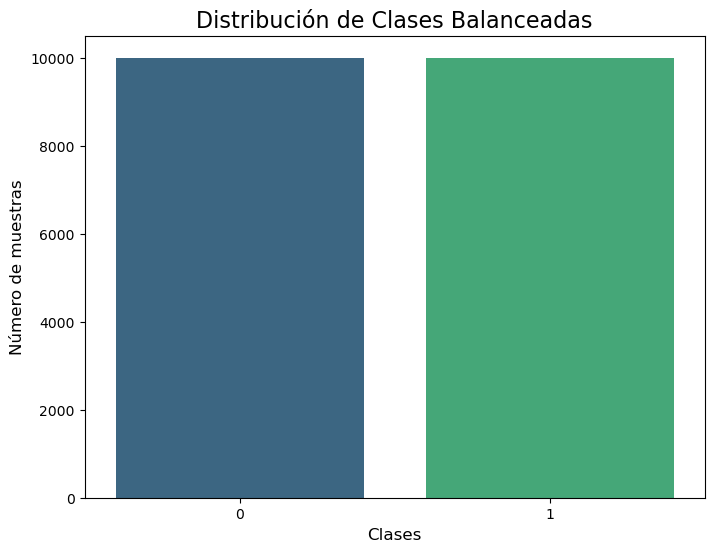

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot para mostrar la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=balanced_data, palette='viridis')
plt.title('Distribución de Clases Balanceadas', fontsize=16)
plt.xlabel('Clases', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from joblib import dump

X = balanced_data.drop(columns=['label'])
y = balanced_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=50)

rf.fit(X_train, y_train)

dump(rf, 'models/maldist.joblib')

y_pred_rf = rf.predict(X_test)

In [6]:
print(f"The score of the algorithm: {rf.score(X_test,y_test)*100}")

The score of the algorithm: 98.15


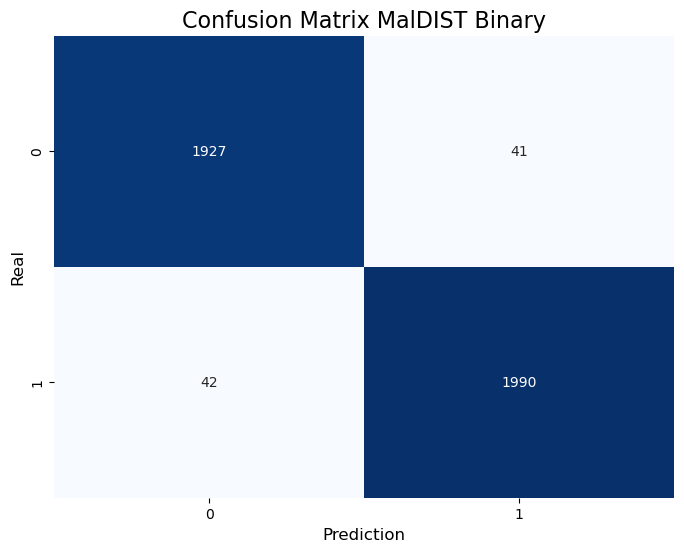

In [11]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['label'].unique(), yticklabels=balanced_data['label'].unique(), cbar=False)
plt.title('Confusion Matrix MalDIST Binary', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real', fontsize=12)

plt.savefig('ConfMat_MalDIST_binary.png', bbox_inches='tight', dpi=300)
plt.show()

In [8]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9792
Precision: 0.9792
Recall: 0.9792
F1 Score: 0.9792
